## Surface Fluxes Taylor Series Expansion
This looks at the taylor series expansion of variables that contribute to each individual flux.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.constants import R
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, get_scale_factor_theory
from isca_tools.thesis.surface_flux_taylor import get_latent_heat, get_sensitivity_lh
import inspect
import copy
import jobs.thesis_season.thesis_figs.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Latent Heat

In [3]:
sigma_atm = 0.995
vals_ref = {'p_surf': 1000 * 100, 'evap_prefactor': 1, 'drag_coef': 0.0009, 'w_atm': 10, 'temp_diseqb': 5, 'rh_atm': 0.7, 'temp_surf': 290}
n_anom = 21
anom_max = {key: vals_ref[key] * 0.5 for key in vals_ref}
anom_max['temp_surf'] = 20
vals = {key: vals_ref[key] + np.linspace(-anom_max[key], anom_max[key], n_anom) for key in vals_ref}
gamma_lh = get_sensitivity_lh(**vals_ref, sigma_atm=sigma_atm)
lh_ref = get_latent_heat(**vals_ref, p_atm=sigma_atm*vals_ref['p_surf'])

In [4]:
colors_use = {'p_surf': 'C5', 'evap_prefactor': 'C6', 'drag_coef': 'C4', 'w_atm': 'C3', 'temp_diseqb': 'C2',
              'rh_atm': 'C0', 'temp_surf': 'C1'}

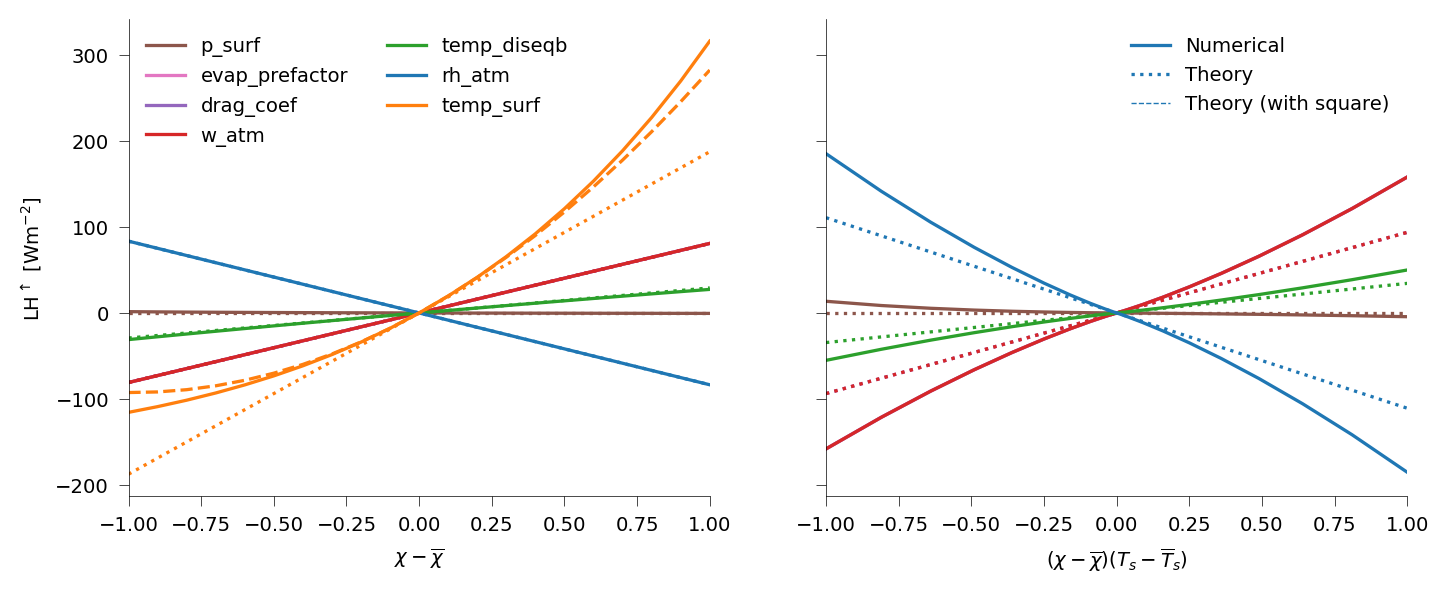

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col']*1.5)
for i, key in enumerate(vals_ref):
    vals_use = copy.deepcopy(vals_ref)
    vals_use[key] = vals[key]
    lh_num = get_latent_heat(**vals_use, p_atm=sigma_atm*vals_use['p_surf']) - lh_ref
    lh_theory = gamma_lh[key] * (vals[key]-vals_ref[key])
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], lh_num, color=colors_use[key], label=key)
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], lh_theory, color=colors_use[key], linestyle=':')
    if key == 'temp_surf':
        # Add squared contribution as important
        lh_theory = lh_theory + gamma_lh[f"nl_{key}_square"] * (vals[key]-vals_ref[key])**2
        ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], lh_theory, color=colors_use[key], linestyle='--')
    else:
        # NL combination with temp_surf
        # Use absolute anomaly for temp_surf, so anom_1*anom_2 goes from negative to positive
        vals_use['temp_surf'] = vals_ref['temp_surf'] + np.abs(vals['temp_surf']-vals_ref['temp_surf'])
        lh_num = get_latent_heat(**vals_use, p_atm=sigma_atm*vals_use['p_surf']) - lh_ref
        # Subtract linear contributions
        for key2 in [key, 'temp_surf']:
            vals_use_nl = copy.deepcopy(vals_ref)
            vals_use_nl[key2] = vals_use[key2]
            lh_num = lh_num - (get_latent_heat(**vals_use_nl, p_atm=sigma_atm*vals_use_nl['p_surf']) - lh_ref)
        vals_use_nl = (vals_use['temp_surf']-vals_ref['temp_surf'])*(vals_use[key]-vals_ref[key])
        lh_theory = gamma_lh[f"nl_temp_surf_{key}"] * vals_use_nl
        ax[1].plot(vals_use_nl/np.max(vals_use_nl), lh_num, color=colors_use[key], label='Numerical' if key=='rh_atm' else None)
        ax[1].plot(vals_use_nl/np.max(vals_use_nl), lh_theory, color=colors_use[key], linestyle=':',
                   label='Theory' if key=='rh_atm' else None)
ax[0].set_ylabel(f"{utils.style_map['lh'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})(T_s-\overline{T}_s)$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['rh_atm'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
update_fontsize(fig, 6)
plt.show()